<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/master/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask or Not

Trains a Neural Network Classifier to predict whether a face image is wearing a mask or not.

Converts the Neural Network Classifier into a Tensorflow-Lite model for deployment to an embedded device (such as an Arduino).

Instructions on how to run on an ESP32 are here: https://github.com/lisaong/stackup-workshops/tree/master/mask-or-not

In [61]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import pickle

In [62]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/master/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
  inflating: data/mask/1.jpg         
  inflating: data/mask/10.jpg        
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
  inflating: data/no_mask/1.jpg      
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      


In [63]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')

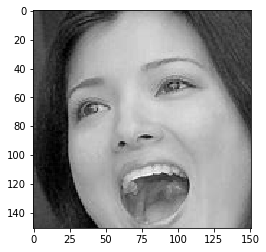

In [64]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [65]:
detect(face_cascade, './data/mask/1.jpg')

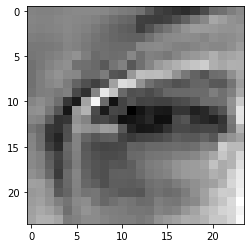

In [66]:
detect(eye_cascade, './data/mask/1.jpg')

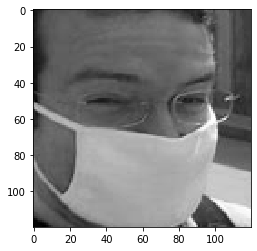

In [67]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

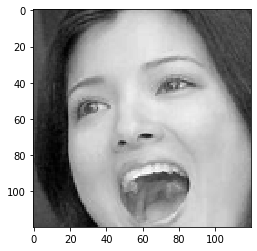

In [68]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

8.jpg


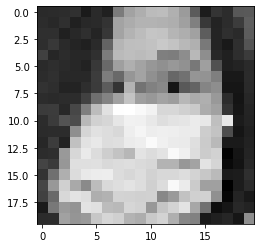

9.jpg


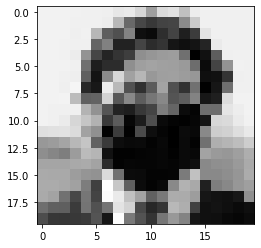

10.jpg


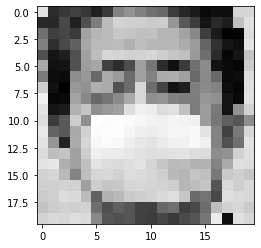

4.jpg


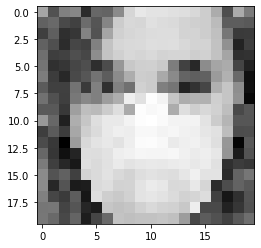

5.jpg


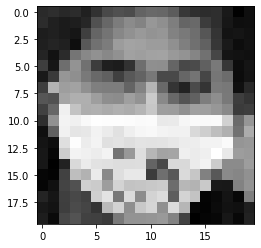

7.jpg


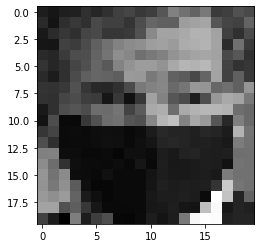

6.jpg


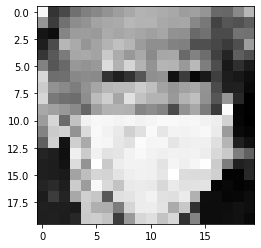

2.jpg


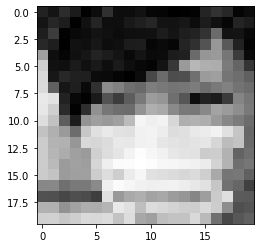

3.jpg


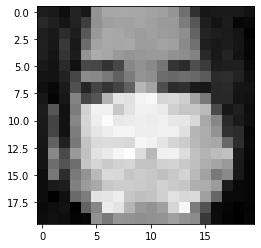

1.jpg


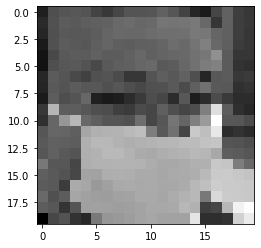

(10, 20, 20)

In [69]:
# Reduce to a small data size so that PCA and the model can fit on ESP32's memory
OUTPUT_SIZE = (20, 20)

def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, 
                                     f'./data/{label}/{path.name}', 
                                     output_size=OUTPUT_SIZE)))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

8.jpg


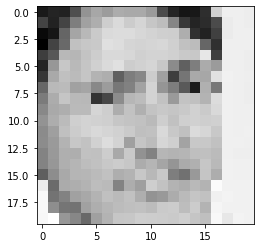

9.jpg


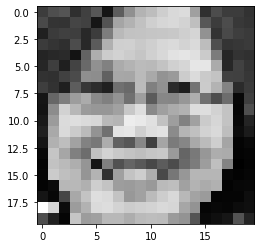

10.jpg


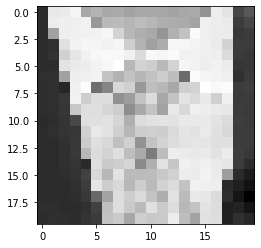

4.jpg


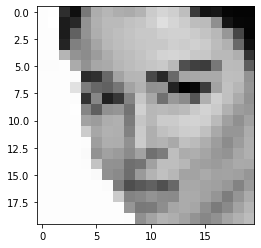

5.jpg


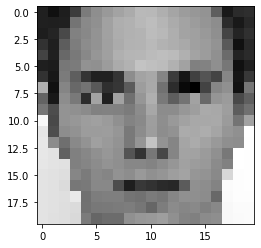

7.jpg


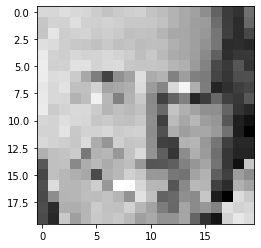

6.jpg


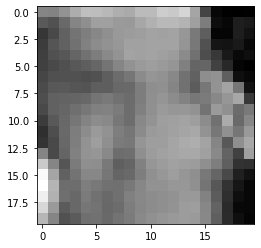

2.jpg


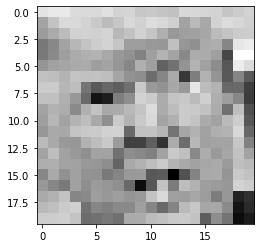

3.jpg


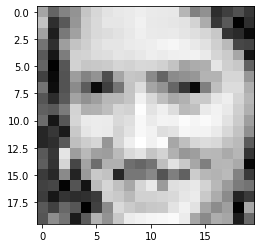

1.jpg


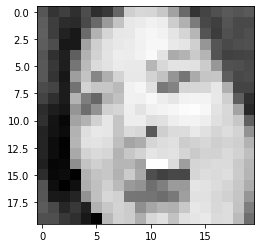

(10, 20, 20)

In [70]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [71]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [72]:
images = np.vstack([images_nomask, images_mask])
images.shape

(20, 20, 20)

In [73]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(20, 400)

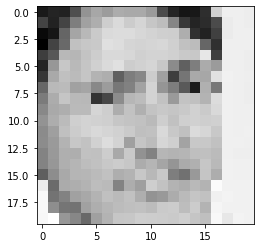

In [74]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [75]:
pca = PCA(n_components=.95)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tune PCA
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([0.24206923, 0.17857815, 0.11894948, 0.08923705, 0.06537185,
       0.05216612, 0.04026701, 0.03131827, 0.02843915, 0.02297775,
       0.02247881, 0.02075178, 0.01669279, 0.01463014, 0.0140107 ])

In [76]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

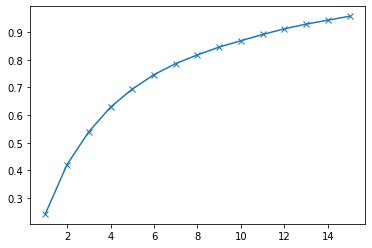

In [77]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [78]:
# choose 7 features
pca = PCA(n_components=7)
Z = pca.fit_transform(X_scaled)

In [79]:
# let's do a pairplot
# df = pd.DataFrame(Z)
# df['label'] = labels
# sns.pairplot(df, hue='label')

In [80]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, random_state=42, stratify=y)

In [82]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8

In [83]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



## Neural Networks

In [84]:
from tensorflow.keras import layers

mlp = tf.keras.Sequential()
mlp.add(layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(layers.Dense(X_train.shape[1], activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 8         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [85]:
tf.keras.utils.plot_model(mlp, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [86]:
# early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mlp.h5', save_best_only=True)

mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, batch_size=5, epochs=80,
                  validation_data=(X_test, y_test),
                  callbacks=[checkpoint])

Epoch 1/80
3/3 [==============================] - 0s 53ms/step - loss: 1.4769 - accuracy: 0.4000 - val_loss: 1.2037 - val_accuracy: 0.4000
Epoch 2/80
3/3 [==============================] - 0s 17ms/step - loss: 1.4288 - accuracy: 0.4000 - val_loss: 1.1988 - val_accuracy: 0.4000
Epoch 3/80
3/3 [==============================] - 0s 16ms/step - loss: 1.3856 - accuracy: 0.4000 - val_loss: 1.1894 - val_accuracy: 0.4000
Epoch 4/80
3/3 [==============================] - 0s 17ms/step - loss: 1.3461 - accuracy: 0.4000 - val_loss: 1.1832 - val_accuracy: 0.4000
Epoch 5/80
3/3 [==============================] - 0s 17ms/step - loss: 1.3126 - accuracy: 0.4000 - val_loss: 1.1783 - val_accuracy: 0.4000
Epoch 6/80
3/3 [==============================] - 0s 16ms/step - loss: 1.2762 - accuracy: 0.4000 - val_loss: 1.1774 - val_accuracy: 0.4000
Epoch 7/80
3/3 [==============================] - 0s 17ms/step - loss: 1.2378 - accuracy: 0.4000 - val_loss: 1.1714 - val_accuracy: 0.4000
Epoch 8/80
3/3 [===========

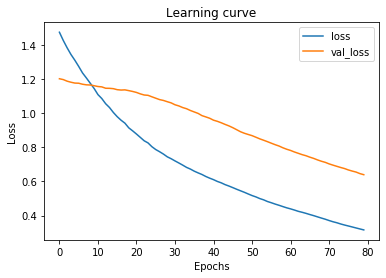

In [87]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [88]:
y_pred = lr.predict(X_test)
baseline_metrics = classification_report(y_test, y_pred)
print(baseline_metrics)

precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [89]:
y_pred_mlp = mlp.predict(X_test) >= 0.5
mlp_metrics = classification_report(y_test, y_pred_mlp)
print(mlp_metrics)

precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      1.00      0.67         2

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5



## Convolutional Neural Networks

8.jpg


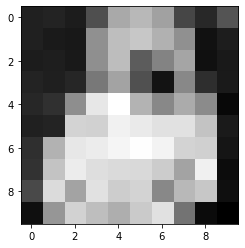

9.jpg


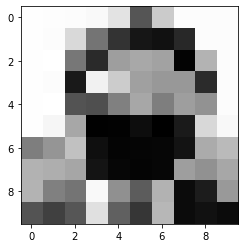

10.jpg


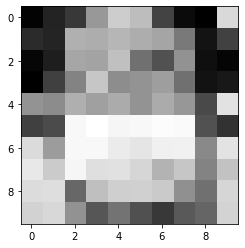

4.jpg


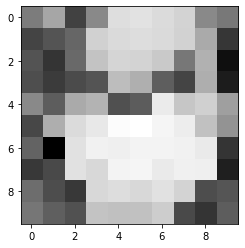

5.jpg


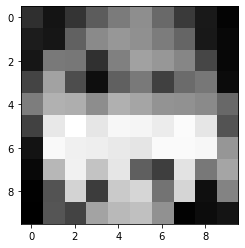

7.jpg


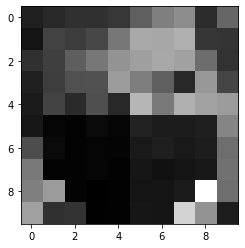

6.jpg


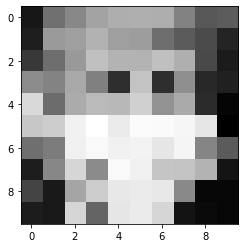

2.jpg


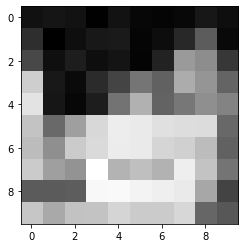

3.jpg


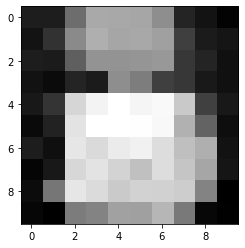

1.jpg


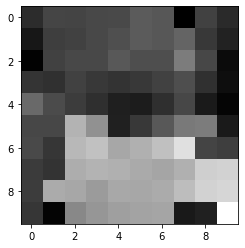

8.jpg


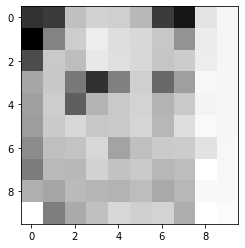

9.jpg


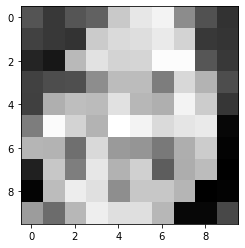

10.jpg


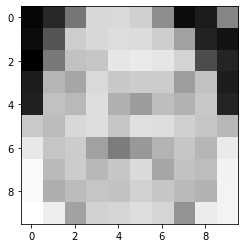

4.jpg


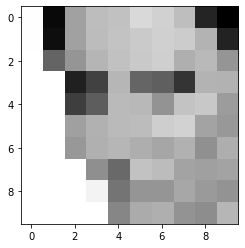

5.jpg


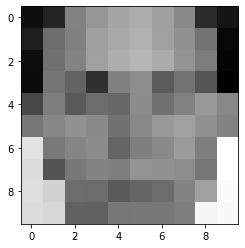

7.jpg


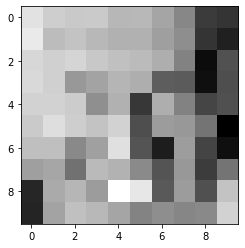

6.jpg


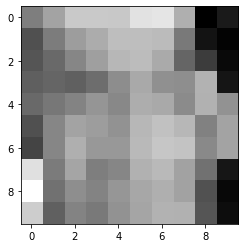

2.jpg


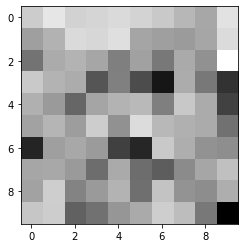

3.jpg


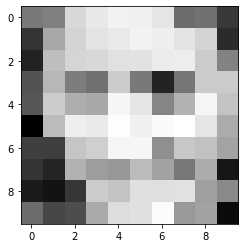

1.jpg


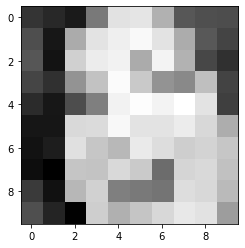

In [90]:
OUTPUT_SIZE = (10, 10)
images_mask = get_image_data('mask')
images_nomask = get_image_data('no_mask')
images = np.vstack([images_nomask, images_mask])

X_cnn = images.reshape(-1, images.shape[1]*images.shape[2])

In [92]:
X_cnn[0]

array([ 53,  60, 168, 182, 180, 161,  60,  30, 197, 211,  12, 119, 178,
       204, 192, 187, 173, 131, 203, 211,  74, 175, 165, 200, 193, 187,
       172, 177, 204, 211, 147, 174, 111,  52, 116, 180,  97, 141, 213,
       211, 141, 178,  89, 157, 175, 184, 157, 175, 210, 211, 139, 176,
       187, 173, 176, 185, 160, 192, 214, 211, 126, 167, 170, 186, 144,
       167, 176, 177, 195, 212, 113, 162, 161, 182, 169, 175, 160, 165,
       219, 212, 154, 146, 163, 159, 157, 165, 149, 160, 213, 213, 219,
       114, 150, 168, 186, 180, 184, 153, 219, 215], dtype=uint8)

In [91]:
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(X_cnn)

X_scaled_reshape = X_scaled.reshape(-1, images.shape[1], images.shape[2], 1)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reshape, y, 
                                                    random_state=42, stratify=y)
X_train.shape

(15, 10, 10, 1)

In [171]:
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
cnn = tf.keras.Sequential()
cnn.add(layers.SeparableConv2D(5, 3, 
        input_shape=(X_train.shape[1],X_train.shape[2], 1), activation='relu'))
#cnn.add(layers.MaxPool2D())
cnn.add(layers.Flatten())
cnn.add(layers.Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_25 (Separab (None, 8, 8, 5)           19        
_________________________________________________________________
flatten_21 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 321       
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________


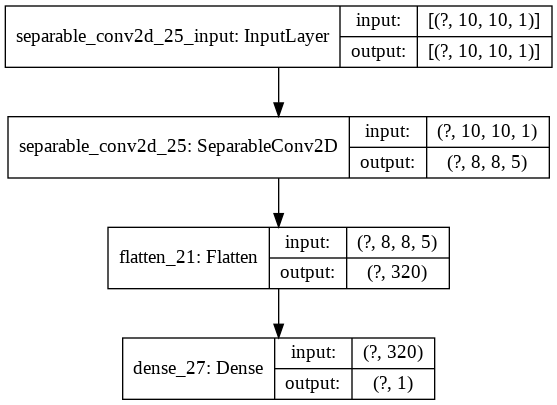

In [172]:
tf.keras.utils.plot_model(cnn, show_shapes=True)

In [173]:
# early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('cnn.h5', save_best_only=True)

cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn.fit(X_train, y_train, batch_size=5, epochs=30,
                  validation_data=(X_test, y_test),
                  callbacks=[checkpoint])

Epoch 1/30
3/3 [==============================] - 0s 42ms/step - loss: 0.7745 - accuracy: 0.6000 - val_loss: 0.9491 - val_accuracy: 0.6000
Epoch 2/30
3/3 [==============================] - 0s 11ms/step - loss: 0.7414 - accuracy: 0.6667 - val_loss: 0.9570 - val_accuracy: 0.6000
Epoch 3/30
3/3 [==============================] - 0s 11ms/step - loss: 0.7189 - accuracy: 0.6667 - val_loss: 0.9536 - val_accuracy: 0.2000
Epoch 4/30
3/3 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.8000 - val_loss: 0.9581 - val_accuracy: 0.2000
Epoch 5/30
3/3 [==============================] - 0s 13ms/step - loss: 0.6694 - accuracy: 0.8000 - val_loss: 0.9615 - val_accuracy: 0.2000
Epoch 6/30
3/3 [==============================] - 0s 12ms/step - loss: 0.6463 - accuracy: 0.8000 - val_loss: 0.9720 - val_accuracy: 0.2000
Epoch 7/30
3/3 [==============================] - 0s 13ms/step - loss: 0.6281 - accuracy: 0.8000 - val_loss: 0.9816 - val_accuracy: 0.2000
Epoch 8/30
3/3 [===========

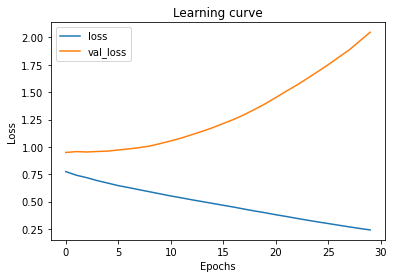

In [174]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [175]:
y_pred_cnn = cnn.predict(X_test) >= 0.5
cnn_metrics = classification_report(y_test, y_pred_cnn)
print(cnn_metrics)

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.00      0.00      0.00         2

    accuracy                           0.20         5
   macro avg       0.17      0.17      0.17         5
weighted avg       0.20      0.20      0.20         5



In [176]:
print(mlp_metrics)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       3.0
           1       0.00      0.00      0.00       2.0

    accuracy                           0.00       5.0
   macro avg       0.00      0.00      0.00       5.0
weighted avg       0.00      0.00      0.00       5.0



In [177]:
print(baseline_metrics)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.50      0.33         2

    accuracy                           0.20         5
   macro avg       0.12      0.25      0.17         5
weighted avg       0.10      0.20      0.13         5



## Quantization to TFLite

https://www.tensorflow.org/lite/microcontrollers/build_convert

In [178]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open('cnn.tflite', 'wb').write(tflite_model)

3248

In [179]:
# Test model loading
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='cnn.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

y_pred_tflite = []

# Test model on input data.
# Loop through each row of test_data and perform inference
for i in range(X_test.shape[0]):

  # add batch dimension
  input_data = np.expand_dims(X_test[i], axis=0).astype('float32')
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  y_pred_tflite.append(output_data[0][0])

print(classification_report(y_test, np.array(y_pred_tflite) >= 0.5))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.00      0.00      0.00         2

    accuracy                           0.20         5
   macro avg       0.17      0.17      0.17         5
weighted avg       0.20      0.20      0.20         5



In [180]:
!pip install tinymlgen

In [183]:
# https://github.com/eloquentarduino/tinymlgen
import tinymlgen

c_code = tinymlgen.port(cnn)

# input should be flattened like this:
#   image_width * image_height * channels
# Ref: https://github.com/tensorflow/tensorflow/blob/59c06b9016700dbf1ab0cefc062d247345cdd0f0/tensorflow/lite/micro/examples/person_detection/image_provider.cc
input_size = cnn.input_shape[1]*cnn.input_shape[2]*cnn.input_shape[3]
output_size = cnn.get_output_shape_at(0)[1]

with open('cnn.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define NUMBER_OF_INPUTS {input_size}\n')
  f.write(f'#define NUMBER_OF_OUTPUTS {output_size}\n')

In [184]:
with open('cnn.h', 'r') as f:
  print(f.read())


#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

const unsigned char model_data[] DATA_ALIGN_ATTRIBUTE = {0x08, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0xba, 0xf9, 0xff, 0xff, 0x03, 0x00, 0x00, 0x00, 0x40, 0x0c, 0x00, 0x00, 0x30, 0x06, 0x00, 0x00, 0x18, 0x06, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x0e, 0x00, 0x00, 0x00, 0x08, 0x06, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0xec, 0x05, 0x00, 0x00, 0xcc, 0x05, 0x00, 0x00, 0xbc, 0x00, 0x00, 0x00, 0xa8, 0x00, 0x00, 0x00, 0x74, 0x00, 0x00, 0x00, 0x50, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x48, 0xf4, 0xff, 0xff, 0x4c, 0xf4, 0xff, 0xff, 0x50, 0xf4, 0xff, 0xff, 0x54, 0xf4, 0xff, 0xff, 0x58, 0xf4,

## Port PCA to Arduino

https://eloquentarduino.github.io/2020/06/arduino-dimensionality-reduction-pca-for-machine-learning-projects/

In [ ]:
!pip install micromlgen

In [ ]:
import micromlgen

c_code = micromlgen.port(pca)
with open('pca.h', 'w') as f:
  f.write(c_code)

  # add defines that will be used by application code
  f.write(f'\n\n#define PCA_INPUT_SIZE {pca.n_features_}\n')

In [ ]:
with open('pca.h', 'r') as f:
  print(f.read())

#pragma once
namespace Eloquent {
    namespace ML {
        namespace Port {
            class PCA {
                public:
                    /**
                    * Apply dimensionality reduction
                    * @warn Will override the source vector if no dest provided!
                    */
                    void transform(float *x, float *dest = NULL) {
                        static float u[7] = { 0 };
                        u[0] = dot(x,   0.009745232911  , 0.040000584354  , 0.037997422895  , 0.034423291992  , 0.047695117338  , 0.035080827361  , 0.032851186065  , 0.009831912302  , -0.010915658149  , -0.024162293427  , -0.039798605596  , -0.014179516541  , 0.003418074705  , 0.007892753752  , 0.027666947  , 0.039567288155  , 0.02932477692  , 0.037270220262  , 0.012983036561  , 0.00840205719  , 0.0303948036  , 0.037882054129  , 0.043333548582  , 0.046022804212  , 0.036001428396  , 0.029817124344  , 0.007549063057  , -0.035889410189  , -0.065687985026  , -0.06591257589

In [ ]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'inputs' : {
        'X' : X,
        'X_cnn' : X_scaled_reshape
    },

    'target' : {
        'y' : y,
        'encoder' : le
    },

    'preprocessors' : {
      'scaler' : scaler,
      'pca' : pca
    },

    'baseline' : {
        'input' : 'X',
        'model' : lr,
        'preprocessors' : [
          'scaler',
          'pca'
        ],
    },

    # model1 spec
    'mlp' : {
        'input' : 'X',
        'scaler' : scaler,
        'preprocessors' : [
          'scaler',
          'pca'                 
        ],
        'h5' : 'mlp.h5'
    },

    # model2 spec
    'cnn' : {
        'input' : 'X_cnn',
        'preprocessors' : [
        ],
        'h5' : 'cnn.h5',
        'tflite' : 'cnn.tflite',
        'h' : 'cnn.h' 
    }
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))

In [ ]:
# tests for continuous integration of the model
import unittest
import numpy as np
import pickle
import tensorflow as tf
from sklearn.metrics import classification_report

class ModelTestcase(unittest.TestCase):
    def setUp(self):
        """Called before every test case."""
        with open('ci_artifacts.pkl', 'rb') as f:
            ci_artifacts = pickle.load(f)
            self.inputs = ci_artifacts['inputs']
            self.target = ci_artifacts['target']
            self.preprocessors = ci_artifacts['preprocessors']
            self.baseline = ci_artifacts['baseline']
            self.mlp = ci_artifacts['mlp']
            self.cnn = ci_artifacts['cnn']

    def tearDown(self):
        """Called after every test case."""
        pass

    def _testSkLearnModel(self, model_spec):
        model = model_spec['model']
        X = self.inputs[model_spec['input']]
        for p in model_spec['preprocessors']:
          X = self.preprocessors[p].transform(X)
        y_pred = model.predict(X)
        print(model)
        print(classification_report(self.target['y'], y_pred))

    def _testTFModel(self, model_spec):
        model = tf.keras.models.load_model(model_spec['h5'])
        X = self.inputs[model_spec['input']]
        for p in model_spec['preprocessors']:
          X = self.preprocessors[p].transform(X)
        y_pred = model.predict(X) >= 0.5
        print(model.summary())
        print(classification_report(self.target['y'], y_pred))

    def testBaseline(self):
        print('Testing Baseline')
        self._testSkLearnModel(self.baseline)

    def testMLP(self):
        print('Testing MLP')
        self._testTFModel(self.mlp)

    def testCNN(self):
        print('Testing CNN')
        self._testTFModel(self.cnn)

    def testCNNTFLite(self):
        print('Testing TFLite Model')
        self._testTFLiteModel(self.cnn)

    def _testTFLiteModel(self, model_spec):
        y_pred = []

        # Load TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_path=model_spec['tflite'])
        interpreter.allocate_tensors()

        # Get input and output tensors.
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        input_shape = input_details[0]['shape']

        # Test model on input data.
        # Loop through each row of test_data and perform inference
        model_input = self.inputs[model_spec['input']]
        for i in range(model_input.shape[0]):

            # add batch dimension
            input_data = np.expand_dims(model_input[i], axis=0).astype('float32')
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()

            # The function `get_tensor()` returns a copy of the tensor data.
            # Use `tensor()` in order to get a pointer to the tensor.
            output_data = interpreter.get_tensor(output_details[0]['index'])
            y_pred.append(output_data[0][0])

        print(classification_report(self.target['y'], np.array(y_pred) >= 0.5))        

if __name__ == '__main__':
    # run all tests
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...

Testing Baseline
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

Testing CNN
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_2 (Separabl (None, 8, 8, 5)           19        
_________________________________________________________________
flatten_2 (Flatten)          (No

.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 8         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________
None
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.70      0.70      0.70        10

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20




----------------------------------------------------------------------
Ran 4 tests in 0.265s

OK
